# K-means Clustering on Local Neighborhoods in Atomically Resolved Images
### Alex Belianinov, Stephen Jesse
The Center for Nanophase Materials Science and The Institute for Functional Imaging for Materials <br>
Oak Ridge National Laboratory<br>
8/1/2018

# Setting up the Notebook

### Before running this you need to conda install openCV (type conda install openCV in the Anaconda Prompt)

In [62]:
# set up notebook to show plots within the notebook
% matplotlib inline

#%% Import necessary Python libraries
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure
import cv2
from scipy.misc import imsave#
from sklearn.neighbors import NearestNeighbors
import math
from scipy.cluster.vq import  whiten
from sklearn.cluster import KMeans
import scipy.optimize as opt
import pyUSID as usid
import h5py
import os

# Tunable Parameters

In [7]:
#Image location for a raw image file (text, tiff, png, etc.)
clean_image_path = r'E:\Dropbox (ORNL)\pycroscopy tutorials\pycroscopy scratchpad\cracked_clean_image.png'

thresh_const = 6 #Constant for thresholding
border = 1 #How many pixels to cut off the clean image before atom finding

boarder_pixels = 25 #Pixels with to eliminate from the edge of each image for atom classification
num_neighbors = 6 #Number of neighbors to designate for the atom classification
color_ops = ['b','r', 'w', 'g', 'c', 'm', 'y', '#3399ff', '#660066', '#4080bf',\
              '#00ffcc', '#aa80ff', '#ff9933', '#1a1aff','#b38600', ' #77b300']


# Data IO, Visualize Clean Image 

800
800


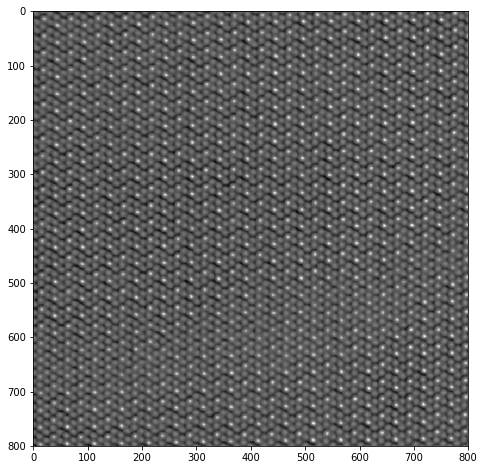

In [8]:
# Read in a cleaned image. The image in this case is a PCA cleaned image. 
# Apply thresholding function to image to identify atom positions.
raw_image = cv2.imread('cracked_clean_image2.png', 0)

image_size_x = raw_image.shape[0]
image_size_y = raw_image.shape[1]

print(image_size_x)
print(image_size_y)

#Show the Image
plt.figure(figsize=(8, 8))
plt.imshow(raw_image,cmap=plt.cm.gray)


In [50]:
translator = usid.ImageTranslator()
h5_raw = translator.translate('cracked_clean_image2.png')

C:\Users\sjz\AppData\Local\Continuum\Anaconda3\lib\site-packages\skimage\io\_io.py:49: UserWarning: `as_grey` has been deprecated in favor of `as_gray`
  warn('`as_grey` has been deprecated in favor of `as_gray`')


ValueError: Unable to create group (name already exists)

<HDF5 dataset "Raw_Data": shape (640000, 1), type "|u1">
located at: 
	/Measurement_000/Channel_000/Raw_Data 
Data contains: 
	Intensity (a.u.) 
Data dimensions and original shape: 
Position Dimensions: 
	X - size: 800 
	Y - size: 800 
Spectroscopic Dimensions: 
	None - size: 1
Data Type:
	uint8

# Binarize the Image by Thresholding 

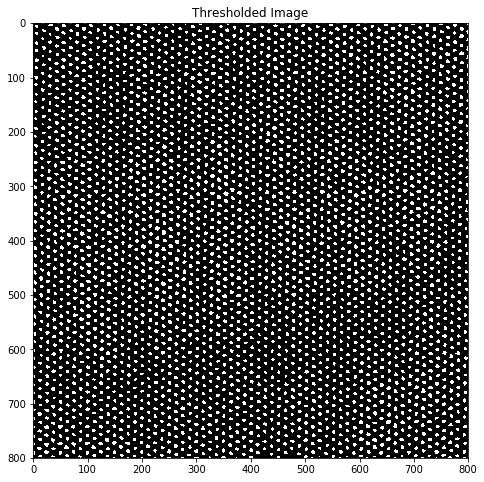

In [25]:
#Invert image because thresholding removes low intenstity values
img_inv = 255- raw_image
threshold_image = cv2.adaptiveThreshold(img_inv,5,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, \
                           cv2.THRESH_BINARY_INV,15,10)
# Plot Thresholded Image
plt.figure(figsize=(8, 8))
plt.imshow(threshold_image, cmap=plt.cm.gray)
plt.title('Thresholded Image')

# Set border on thresholded image for cropping to find atoms
threshold_image_new = threshold_image[border:-border,border:-border]

# Find the Atoms and Display Findings Over the Image

## Set the Image Border Size 

(-43.58118279569892, 842.581182795699, 842.7065121412803, -43.7065121412805)

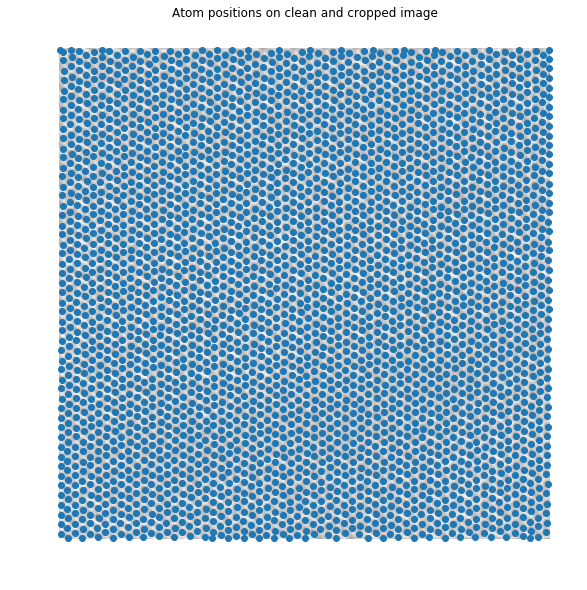

In [26]:
# calculate atom center of mass from atom positions. This step finds the atoms.
all_labels = measure.label(threshold_image_new)
atom_labels = measure.label(threshold_image_new)

num_atoms = np.max(atom_labels)-1
atom_positions = np.zeros(shape=(num_atoms, 2), dtype=np.float)

for atom_ind in range(1,num_atoms):
    atom_pixels = np.argwhere(atom_labels == atom_ind)
    atom_positions[atom_ind] = np.mean(atom_pixels, axis=0)

# Plot the atom positions on the cleaned image
plt.figure(figsize=(10,10))  
plt.imshow(raw_image, cmap='Greys', interpolation='none') 
atom_positions = np.flipud(np.rot90(atom_positions,2)) #to orient atom_positions
                                               #with respect the the cropped image
    
plt.scatter(atom_positions[:,0] + border, atom_positions[:,1]+ border)
plt.title('Atom positions on clean and cropped image')
plt.axis('off')

In [56]:
h5_file = h5_raw.file
usid.hdf_utils.print_tree(h5_file)

/
├ Measurement_000
  ---------------
  ├ Channel_000
    -----------
    ├ Position_Indices
    ├ Position_Values
    ├ Raw_Data
    ├ Spectroscopic_Indices
    ├ Spectroscopic_Values


In [57]:
h5_group = usid.hdf_utils.create_results_group(h5_raw,'atom_finding')

In [58]:
h5_atom_pos = usid.hdf_utils.write_main_dataset(h5_group, atom_positions,'Atom_Positions','coordinates','pixels',
                                                usid.Dimension('atom_index','a.u.',atom_positions.shape[0]),
                                                usid.Dimension('axis','pixels',atom_positions.shape[1]))

In [60]:
usid.hdf_utils.print_tree(h5_file)
h5_atom_pos

/
├ Measurement_000
  ---------------
  ├ Channel_000
    -----------
    ├ Position_Indices
    ├ Position_Values
    ├ Raw_Data
    ├ Raw_Data-atom_finding_000
      -------------------------
      ├ Atom_Positions
      ├ Position_Indices
      ├ Position_Values
      ├ Spectroscopic_Indices
      ├ Spectroscopic_Values
    ├ Spectroscopic_Indices
    ├ Spectroscopic_Values


<HDF5 dataset "Atom_Positions": shape (3275, 2), type "<f8">
located at: 
	/Measurement_000/Channel_000/Raw_Data-atom_finding_000/Atom_Positions 
Data contains: 
	coordinates (pixels) 
Data dimensions and original shape: 
Position Dimensions: 
	atom_index - size: 3275 
Spectroscopic Dimensions: 
	axis - size: 2
Data Type:
	float64

## Refine atom positions using a gaussian fit of each atom and its nearest neighbors

In [27]:
atom_positions.shape
num_atoms

cropped_image = raw_image[border:-border, border:-border]

def gauss_2D(fitting_space, amplitude, xo, yo, sigma, offset):
    x = fitting_space[0]
    y = fitting_space[1]
    xo = float(xo)
    yo = float(yo)    
    r = ((x-xo)**2 + (y-yo)**2)**.5;
    g = amplitude*np.exp(-(r/sigma)**2)+offset;
    return g.ravel()
   
b = 12 #window size
    
# Create fitting space
x_vec = np.linspace(-b/2, b/2, b)
y_vec = np.linspace(-b/2, b/2, b)
x_mat, y_mat = np.meshgrid(x_vec, y_vec)

print(x_mat.shape)

atomic_positions_corrections = np.zeros(atom_positions.shape)

# do a fit of each atom using a radially symmetric gaussian
for k1 in range(0,num_atoms-1):
    ax = atom_positions[k1,0]
    ay = atom_positions[k1,1]
    t1 = int((ax>b)) 
    t2 = int(ax<(image_size_x-b))
    t3 = int((ay>b)) 
    t4 = int(ay<(image_size_y-b))

    if (t1+t2+t3+t4)==4:
        ROI = cropped_image[int(ay-b/2):int(ay+b/2),int(ax-b/2):int(ax+b/2)]
        amp_guess = ROI[int(b/2),int(b/2)]
        initial_guess = (amp_guess, 0, 0, 5, 0) 
        guess = gauss_2D((x_mat, y_mat), *initial_guess)
        guess_surface = guess.reshape(b,b)
        popt, pcov = opt.curve_fit(gauss_2D, (x_mat, y_mat), ROI.ravel(), p0=initial_guess)
        
        # need to make sure x and y are correct
        atomic_positions_corrections[k1,0] = popt[1]
        atomic_positions_corrections[k1,1] = popt[2]
        
        fitted_surface = gauss_2D((x_mat, y_mat), *popt)
        fitted_surface = fitted_surface.reshape(b,b)

(12, 12)


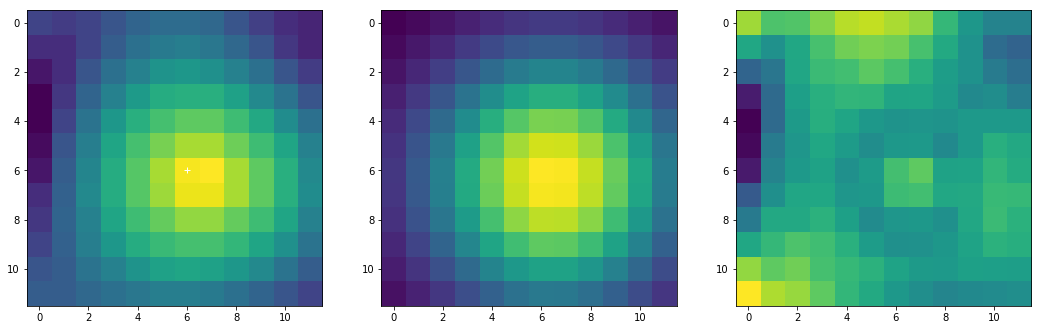

In [28]:
plt.figure(1,figsize=(18,6))
plt.subplot(131)
plt.imshow(ROI)
plt.plot(b/2,b/2,'w+')
plt.subplot(132)
plt.imshow(fitted_surface)
plt.subplot(133)
plt.imshow(ROI-fitted_surface)
        

# Save the Atom Positions & Crop Empty Image Space

In [29]:
# Saving the atom positions

#save atom positions
x_y_positions = np.array(atom_positions, dtype='float64')
atom_path = 'atom_positions.txt'
np.savetxt(atom_path, x_y_positions)

#cropped image 
image_cropped = raw_image[border:-border, border:-border]

# Eliminate Edge Atoms as Centers but Leave them as Neighbors

In [30]:
# Edge Atom Eliminator for k-means algorithm 
cut_x, cut_y = image_cropped.shape
x_y_positions_edge_cut = np.zeros((x_y_positions.shape[0],2))

for t in range(0,x_y_positions.shape[0]):
    
    if boarder_pixels < x_y_positions[t,0] and x_y_positions[t,0] < cut_x-boarder_pixels \
       and boarder_pixels < x_y_positions[t,1] and x_y_positions[t,1] < cut_x - boarder_pixels:
           
        x_y_positions_edge_cut[t,:] = x_y_positions[t,:]
        
all_x = x_y_positions_edge_cut[:,0]
all_y = x_y_positions_edge_cut[:,1]
               

# Find a Specified Number of Nearest Neighbors for All Atoms

In [31]:
# Find specified number of neighbors around (x,y) position. Outputs indices of all neighbors and distance to them
              
nbrs = NearestNeighbors(n_neighbors=num_neighbors+1, algorithm='brute').fit(x_y_positions)
distance_vec, full_index = nbrs.kneighbors(x_y_positions)

nn_index = full_index[:,1:] 


In [32]:
# rename for convenience
atom_pos_cen = x_y_positions_edge_cut;
atom_pos_all = atom_positions;

## get measurements to nearest neighbors of every atom

In [33]:

num_atoms = atom_pos_all.shape[0]
d_vec = np.zeros((1,6),dtype=float)
a_vec = d_vec.copy()
xd_vec = d_vec.copy()
yd_vec = d_vec.copy()
d_mat = np.zeros((num_atoms,6),dtype=float)
a_mat = d_mat.copy()
xd_mat = d_mat.copy()
yd_mat = d_mat.copy()
#build a matrix of measurements from each atom to its nearest neighbors
for k1 in range(0,num_atoms-1):
    x0 = atom_pos_cen[k1,0]
    y0 = atom_pos_cen[k1,1]
    if ((int(x0==0)+int(y0==0))==0):
        for k2 in range(0,6):            
            x1 = atom_pos_all[nn_index[k1,k2],0]
            y1 = atom_pos_all[nn_index[k1,k2],1]
            d_vec[0,k2] = np.abs((x0-x1)+1j*(y0-y1)) #array of distances from each atom to its nearest neighbors
            a_vec[0,k2] = np.angle((x0-x1)+1j*(y0-y1)) #array of angles from each atom to its nearest neighbors
            xd_vec[0,k2] = (x0-x1)
            yd_vec[0,k2] = (y0-y1)
            
        # sort neighbors based on angle
        sort_ind = np.argsort(a_vec[0,:],axis=None)
        d_mat[k1,:] = d_vec[0,sort_ind]
        a_mat[k1,:] = a_vec[0,sort_ind]
        xd_mat[k1,:] = xd_vec[0,sort_ind]
        yd_mat[k1,:] = yd_vec[0,sort_ind]


(-16.63762320788531,
 16.637623207885305,
 -20.425449469086363,
 20.425449469086367)

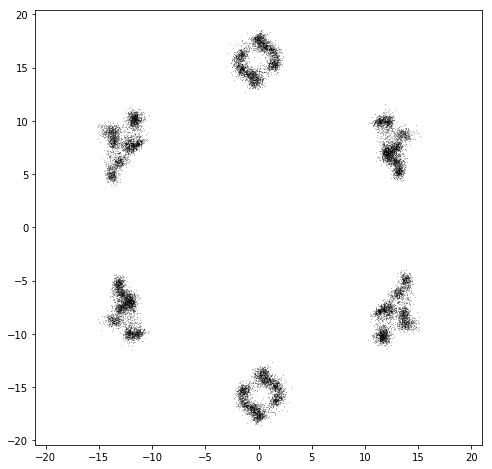

In [34]:
# remove border atoms from the list of atoms - they only complicate analysis 
keep = (atom_pos_cen[:,0]+atom_pos_cen[:,1])>0

d_mat2 = d_mat[keep]
a_mat2 = a_mat[keep]
xd_mat2 = xd_mat[keep]
yd_mat2 = yd_mat[keep]
atom_pos_2 = atom_pos_all[keep] + atomic_positions_corrections[keep]

# plot clouds of nearest neighbor positions relative to each atom
plt.figure(1,figsize=(8,8))
plt.scatter(xd_mat2,yd_mat2,c='k',s=.01)
plt.axis('equal')


# DO SVD on nearest neighbor positions and/or angles

## do SVD

In [35]:
# do svd
[ud,sd,vd] = np.linalg.svd(d_mat2,full_matrices=0) #SVD on radial distance of nearest neighbors
[ua,sa,va] = np.linalg.svd(a_mat2,full_matrices=0) #SVD on anglular displacement of nearest neighbors

[us,ss,vs] = np.linalg.svd(xd_mat2+1j*yd_mat2,full_matrices=0) #SVD on relative position of nearest neighbors (complex valued)

#convert complex results of 
usm = np.abs(us)
usa = np.angle(us)
usx = np.real(us)
usy = np.imag(us)

vsm = np.abs(vs)
vsa = np.angle(vs)
vsx = np.real(vs)
vsy = np.imag(vs)

# Plot results of SVD on nearest neighbors

### Look at the results of SVD on radial distances only

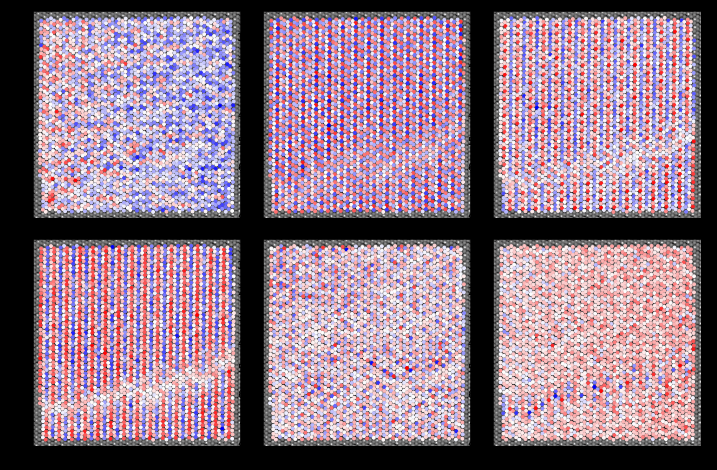

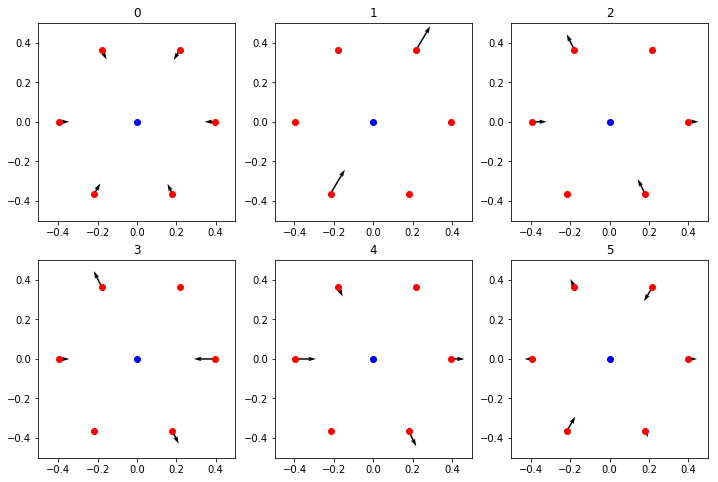

In [36]:
# plot eigenvalue radial displacements
fig, axs = plt.subplots(2,3, figsize=(12, 8), facecolor='black', edgecolor='w')
fig.subplots_adjust(hspace = .1, wspace=.1)
axs = axs.ravel()
for k1 in range(0,6):
    up = ud[:,k1]
    up = up-up.min()
    up = up/up.max()
    colors = plt.cm.bwr(up)
    axs[k1].imshow(1-raw_image, cmap='Greys', interpolation='none',alpha=1)
    axs[k1].scatter(atom_pos_2[:,0]+border,atom_pos_2[:,1]+border,c=colors,s=8)
    
# plot eigenvector maps of radial displacement eigenvectors
fig, axs = plt.subplots(2,3, figsize=(12, 8))
fig.subplots_adjust(hspace = .2, wspace=.2)
axs = axs.ravel()
for k1 in range(0,6):
    axs[k1-1].plot(0,0,'bo')
    axs[k1-1].plot(vsx[0,:],vsy[0,:],'ro')
    #axs[k1].axis('off')    
    axs[k1].axis('equal')
    c = .5
    axs[k1].axis([-c, c, -c, c])
    axs[k1].set_title(str(k1))
    axs[k1].quiver(vsx[0,:],vsy[0,:],vsx[0,:]*vd[k1,:],vsy[0,:]*vd[k1,:])

### Look at the results of SVD on relative angles only

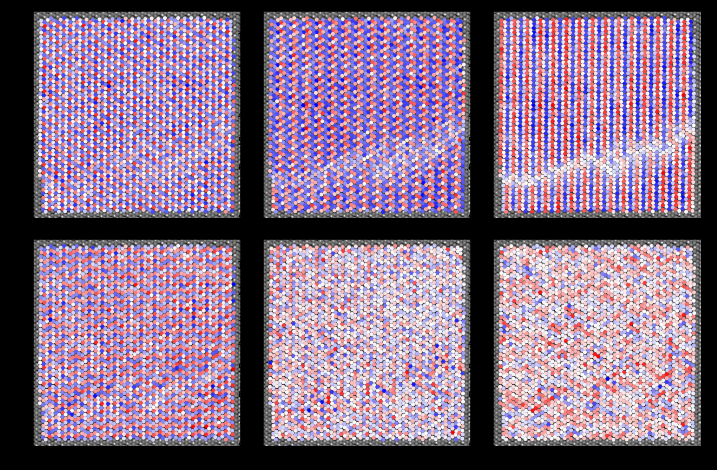

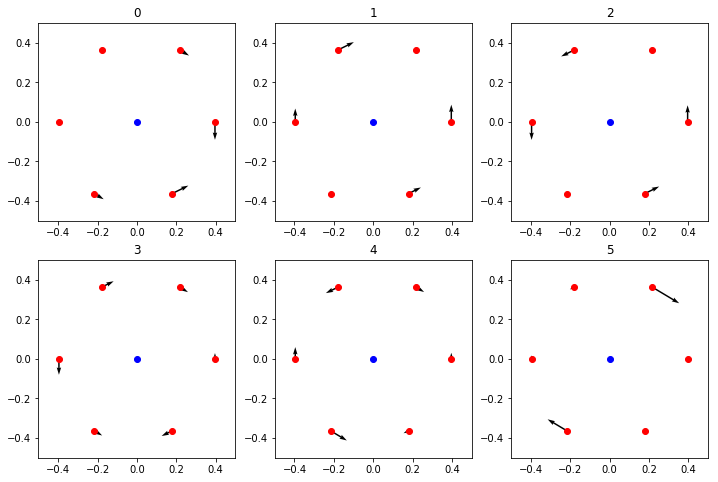

In [37]:
# plot eigenvalue maps of angle
fig, axs = plt.subplots(2,3, figsize=(12, 8), facecolor='black', edgecolor='w')
fig.subplots_adjust(hspace = .1, wspace=.1)
axs = axs.ravel()
for k1 in range(0,6):
    up = ua[:,k1]
    up = up-up.min()
    up = up/up.max()
    colors = plt.cm.bwr(up)
    axs[k1].imshow(1-raw_image, cmap='Greys', interpolation='none',alpha=1)
    axs[k1].scatter(atom_pos_2[:,0]+border,atom_pos_2[:,1]+border,c=colors,s=8)
    

# plot eigenvector maps of radial displacement eigenvectors
fig, axs = plt.subplots(2,3, figsize=(12, 8))
fig.subplots_adjust(hspace = .2, wspace=.2)
axs = axs.ravel()
alpha = np.arctan2(vsy[0,:],vsx[0,:])
for k1 in range(0,6):
    axs[k1-1].plot(0,0,'bo')
    axs[k1-1].plot(vsx[0,:],vsy[0,:],'ro')
    #axs[k1].axis('off')    
    axs[k1].axis('equal')
    c = .5
    axs[k1].axis([-c, c, -c, c])
    axs[k1].set_title(str(k1))    
    #axs[k1].quiver(vsx[0,:],vsy[0,:],1,1)
    axs[k1].quiver(vsx[0,:],vsy[0,:],np.sin(alpha)*va[k1,:],-np.cos(alpha)*va[k1,:])

### Look at the results of SVD on combined x and y relative displacements

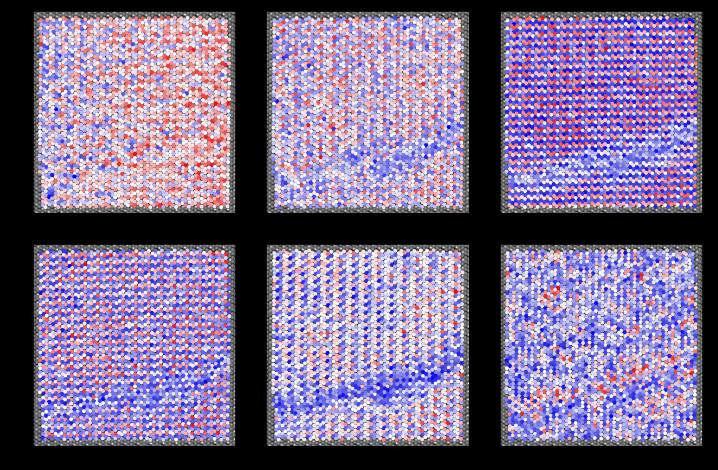

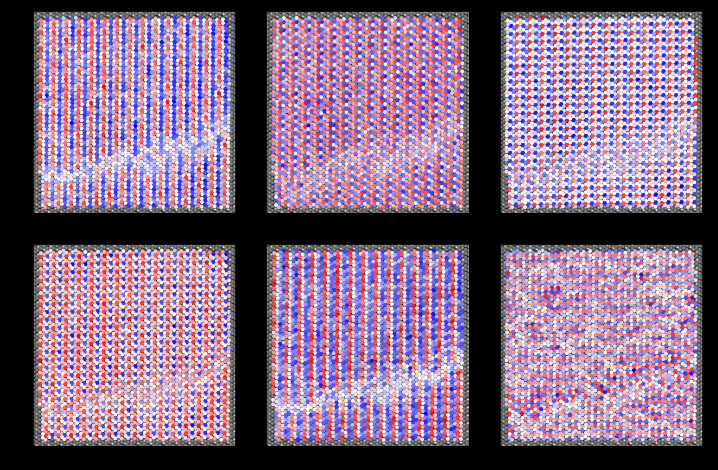

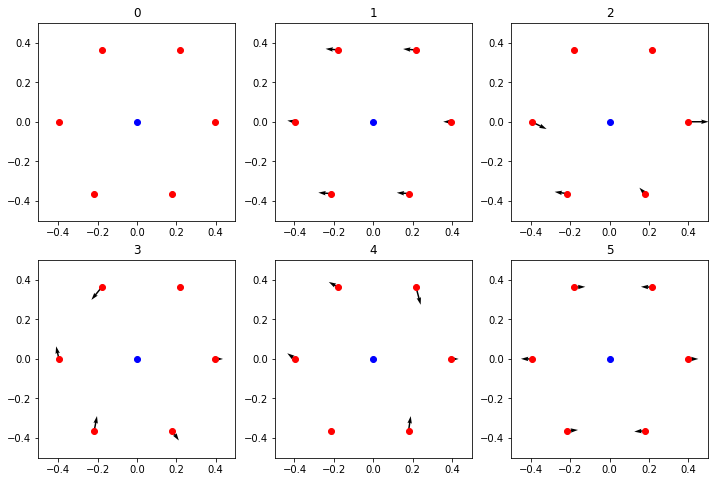

In [38]:
# plot eigenvalue maps of combined 2D displacement 
fig, axs = plt.subplots(2,3, figsize=(12, 8), facecolor='black', edgecolor='w')
fig.subplots_adjust(hspace = .15, wspace=.15)
axs = axs.ravel()
for k1 in range(0,6):
    up = usm[:,k1]
    up = up-up.min()
    up = up/up.max()
    colors = plt.cm.bwr(up)
    axs[k1].imshow(1-raw_image, cmap='Greys', interpolation='none',alpha=1)
    axs[k1].scatter(atom_pos_2[:,0]+border,atom_pos_2[:,1]+border,c=colors,s=8)
    
fig, axs = plt.subplots(2,3, figsize=(12, 8), facecolor='black', edgecolor='w')
fig.subplots_adjust(hspace = .15, wspace=.15)
axs = axs.ravel()
for k1 in range(0,6):
    up = usy[:,k1]
    up = up-up.min()
    up = up/up.max()
    colors = plt.cm.bwr(up)
    axs[k1].imshow(1-raw_image, cmap='Greys', interpolation='none',alpha=1)
    axs[k1].scatter(atom_pos_2[:,0]+border,atom_pos_2[:,1]+border,c=colors,s=8)

# plot eigenvector maps of combined 2D displacement displacement to show modes of distortion
fig, axs = plt.subplots(2,3, figsize=(12, 8))
fig.subplots_adjust(hspace = .2, wspace=.2)
axs = axs.ravel()
for k1 in range(0,6):  
    axs[k1-1].plot(0,0,'bo')
    axs[k1-1].plot(vsx[0,:],vsy[0,:],'ro')
    axs[k1].axis('equal')
    c = .5
    axs[k1].axis([-c, c, -c, c])
    axs[k1].set_title(str(k1))
    if(k1>0):
        axs[k1].quiver(vsx[0,:],vsy[0,:],vsx[k1,:],vsy[k1,:])

# Do clustering on atom positions

In [64]:
# Sort into clusters by distance or angle to neighbors 
num_cluster = 6
IDX = KMeans(n_clusters= num_cluster, max_iter=1000).fit_predict(a_mat2)
IDX = IDX + 1 #So that we don't divide by 0 later

## Plot results of clustering

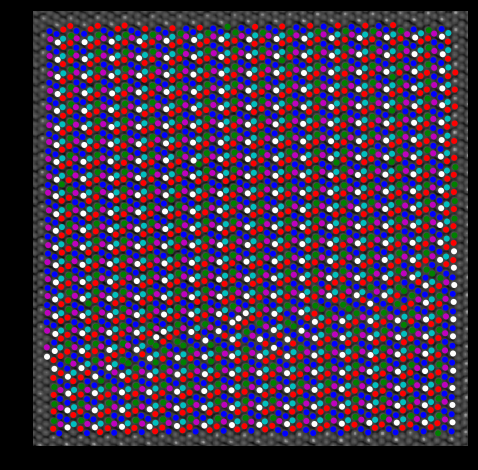

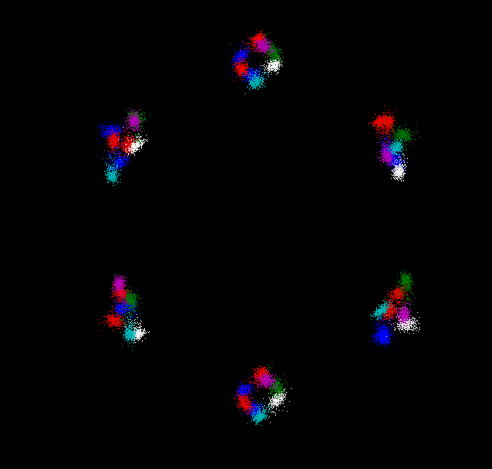

In [65]:
# plot the locations across the map where the different clusters
plt.figure(1,figsize=(8,8),facecolor='black')
plt.axis('off')
plt.imshow(image_cropped, cmap = 'gray',alpha=.75)
for k1 in range(1, num_cluster +1):
    plt.scatter(atom_pos_2[IDX == k1,0], atom_pos_2[IDX == k1, 1], c = color_ops[k1-1], edgecolors= 'none')
    
# make a scatter plot showing clustering relative to a central atom
plt.figure(2,figsize=(8,8),facecolor='black')
plt.axis('equal')
plt.axis('off')
for k1 in range(1, num_cluster +1):
    plt.scatter(xd_mat2[IDX == k1,:],yd_mat2[IDX == k1,:],c = color_ops[k1-1],s=.05)

In [61]:
h5_path =h5_file.filename
h5_file.close()


In [63]:
os.remove(h5_path)

ValueError: Not a valid object id (invalid object ID)